# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

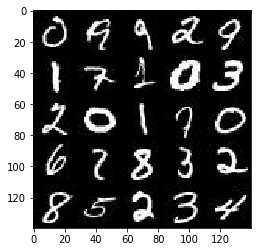

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

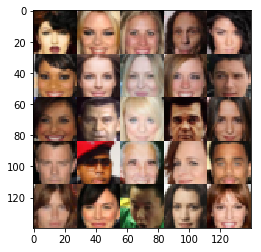

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        filter_size = 5
        alpha = 0.2
        # 28x28x3 to 56*56*64
        x1 = tf.layers.conv2d(images, 64, filter_size, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 56*56*64 to 112*112*128
        x2 = tf.layers.conv2d(relu1, 128, filter_size, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn1, bn1)
        
        # 112*112*128 to 224*224*256
        x3 = tf.layers.conv2d(relu2, 256, filter_size, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn2, bn2)
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        # to 7*7*512
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # 7*7*512 to 14*14*256
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        # 14*14*256 to 28*28*3
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    variables = tf.trainable_variables()
    d_vars = [var for var in variables if var.name.startswith('discriminator')]
    g_vars = [var for var in variables if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    print_every = 10
    show_every = 100
    #saver = tf.train.Saver()    
    
    image_channels = 3 if 'RGB' == data_image_mode else 1
    inputs_real, inputs_z, _ = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Review
                # The output from the generator is bound between -1 and 1 as we use tanh as the activation function 
                # in the output layer. The input batch images are in the range -0.5 to 0.5. 
                # You must scale the input images to match the values as in generated image
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    _ = show_generator_output(sess, 10, inputs_z, image_channels, data_image_mode)
          
        #saver.save(sess, './checkpoints/generator.ckpt')      
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1571... Generator Loss: 2.3524
Epoch 1/2... Discriminator Loss: 0.1043... Generator Loss: 3.5071
Epoch 1/2... Discriminator Loss: 0.0495... Generator Loss: 3.7993
Epoch 1/2... Discriminator Loss: 4.0817... Generator Loss: 4.7046
Epoch 1/2... Discriminator Loss: 0.4791... Generator Loss: 1.4366
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 2.1747
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 1.3888


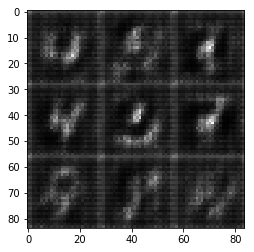

Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 1.4149
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 0.9893
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.9967
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.0020


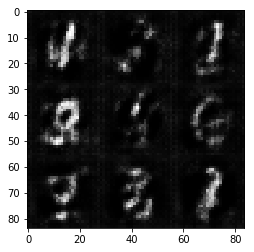

Epoch 1/2... Discriminator Loss: 1.6793... Generator Loss: 0.2687
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.1435
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 1.3240
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 1.7734
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 2.4115
Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 0.9125
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 2.1158
Epoch 1/2... Discriminator Loss: 0.6638... Generator Loss: 1.4215


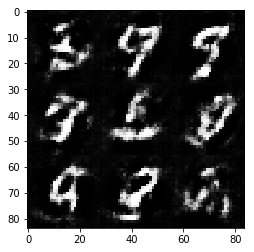

Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 2.7337
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.3893
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 0.6118... Generator Loss: 1.9873
Epoch 1/2... Discriminator Loss: 0.7351... Generator Loss: 0.9072
Epoch 1/2... Discriminator Loss: 0.8644... Generator Loss: 0.7292
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.7817
Epoch 1/2... Discriminator Loss: 0.6517... Generator Loss: 1.5128
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 1.2255


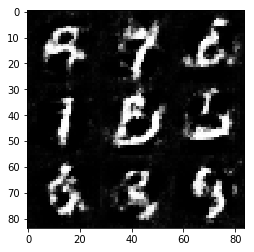

Epoch 1/2... Discriminator Loss: 0.6867... Generator Loss: 1.2065
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 1.1494
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.6282
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 2.6256
Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.4804
Epoch 2/2... Discriminator Loss: 0.6558... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.7086
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 1.8274
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 2.0402


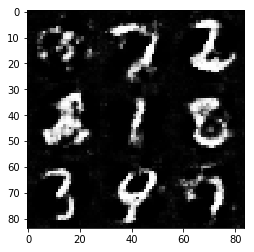

Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 0.9332
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 1.7804
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.3848
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.0815


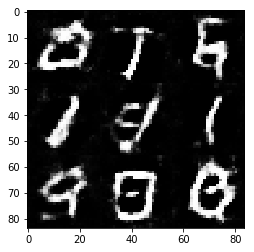

Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 2.3787
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 1.8332
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 2.1660
Epoch 2/2... Discriminator Loss: 0.8025... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 0.6643
Epoch 2/2... Discriminator Loss: 0.7605... Generator Loss: 1.0704
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 2.2914
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.1225
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.4626
Epoch 2/2... Discriminator Loss: 0.7094... Generator Loss: 1.1182


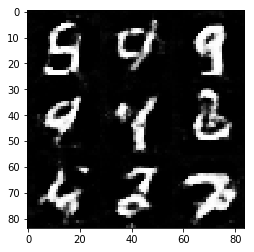

Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 2.2352
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 0.6198... Generator Loss: 1.4554
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.8756
Epoch 2/2... Discriminator Loss: 0.8606... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 0.8120... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.3598
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 2.1941
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.5554


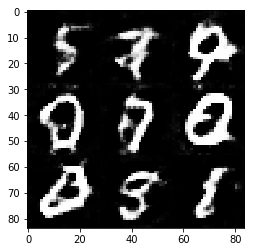

Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.6208
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.4541
Epoch 2/2... Discriminator Loss: 0.5620... Generator Loss: 1.2418
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 1.5826
Epoch 2/2... Discriminator Loss: 0.7495... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.4160
Epoch 2/2... Discriminator Loss: 0.6289... Generator Loss: 1.3145
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 0.7991


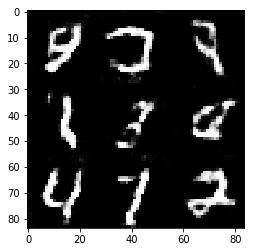

Epoch 2/2... Discriminator Loss: 0.6197... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.9989


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 0.6913... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 1.7803
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 2.0095
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 2.3407
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.4848
Epoch 1/2... Discriminator Loss: 1.6517... Generator Loss: 0.3878
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 1.6128
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.9377
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.5146


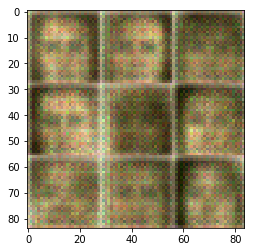

Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.8870
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 1.9945... Generator Loss: 0.2085
Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 0.7947... Generator Loss: 2.7119
Epoch 1/2... Discriminator Loss: 1.7875... Generator Loss: 0.2646
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 1.7666


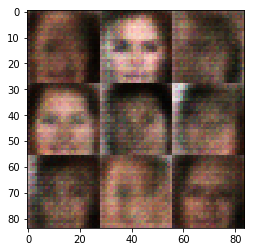

Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 0.5506... Generator Loss: 1.9477
Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 2.2738
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 3.6893
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 0.6750
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 1.7743
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 2.2328... Generator Loss: 0.1749


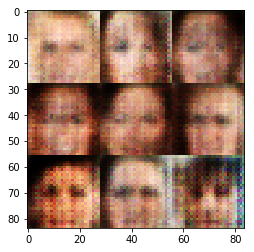

Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 2.0729... Generator Loss: 0.1962
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.4179
Epoch 1/2... Discriminator Loss: 0.4224... Generator Loss: 2.3674
Epoch 1/2... Discriminator Loss: 1.9781... Generator Loss: 0.2092
Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 1.4479
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 2.2624
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.5072
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 1.5671


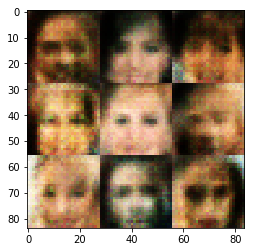

Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 1.8722
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 0.3759... Generator Loss: 1.7536
Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 0.3002... Generator Loss: 2.1697
Epoch 1/2... Discriminator Loss: 1.7358... Generator Loss: 0.2571
Epoch 1/2... Discriminator Loss: 0.4725... Generator Loss: 1.4980
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 0.2055... Generator Loss: 4.8114


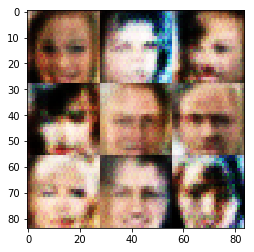

Epoch 1/2... Discriminator Loss: 0.1472... Generator Loss: 3.5041
Epoch 1/2... Discriminator Loss: 0.1980... Generator Loss: 2.4215
Epoch 1/2... Discriminator Loss: 0.2162... Generator Loss: 2.5603
Epoch 1/2... Discriminator Loss: 0.1983... Generator Loss: 2.9666
Epoch 1/2... Discriminator Loss: 0.2165... Generator Loss: 2.8604
Epoch 1/2... Discriminator Loss: 0.0838... Generator Loss: 3.5201
Epoch 1/2... Discriminator Loss: 0.0487... Generator Loss: 5.7139
Epoch 1/2... Discriminator Loss: 0.2713... Generator Loss: 3.2813
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 2.0219... Generator Loss: 0.1736


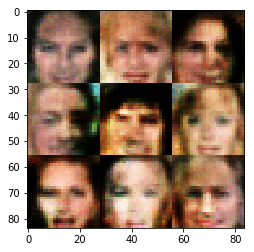

Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 1.5701... Generator Loss: 0.2840
Epoch 1/2... Discriminator Loss: 0.4843... Generator Loss: 1.1033
Epoch 1/2... Discriminator Loss: 0.0806... Generator Loss: 6.3662
Epoch 1/2... Discriminator Loss: 0.2021... Generator Loss: 2.0729
Epoch 1/2... Discriminator Loss: 0.0942... Generator Loss: 5.0645
Epoch 1/2... Discriminator Loss: 0.1128... Generator Loss: 3.9772
Epoch 1/2... Discriminator Loss: 0.0984... Generator Loss: 6.9458
Epoch 1/2... Discriminator Loss: 0.0488... Generator Loss: 4.7844
Epoch 1/2... Discriminator Loss: 0.1380... Generator Loss: 7.4001


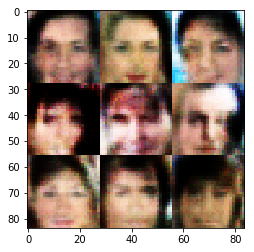

Epoch 1/2... Discriminator Loss: 0.0794... Generator Loss: 3.2493
Epoch 1/2... Discriminator Loss: 0.1342... Generator Loss: 2.9684
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 0.2857... Generator Loss: 1.7307
Epoch 1/2... Discriminator Loss: 0.0721... Generator Loss: 8.5835
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 1.3228
Epoch 1/2... Discriminator Loss: 0.1777... Generator Loss: 2.1785
Epoch 1/2... Discriminator Loss: 0.0273... Generator Loss: 7.4545
Epoch 1/2... Discriminator Loss: 0.0553... Generator Loss: 6.1028
Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 8.2276


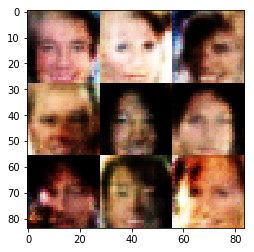

Epoch 1/2... Discriminator Loss: 0.1597... Generator Loss: 5.3903
Epoch 1/2... Discriminator Loss: 0.1392... Generator Loss: 3.3357
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.4844
Epoch 1/2... Discriminator Loss: 0.2299... Generator Loss: 1.9662
Epoch 1/2... Discriminator Loss: 0.4575... Generator Loss: 9.2380
Epoch 1/2... Discriminator Loss: 0.0255... Generator Loss: 5.8155
Epoch 1/2... Discriminator Loss: 0.1131... Generator Loss: 3.9289
Epoch 1/2... Discriminator Loss: 0.0598... Generator Loss: 5.0734
Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 7.2625
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.5218


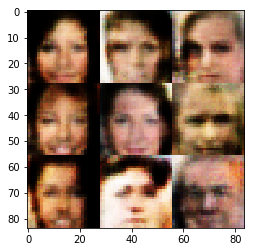

Epoch 1/2... Discriminator Loss: 0.0944... Generator Loss: 3.3088
Epoch 1/2... Discriminator Loss: 0.3511... Generator Loss: 1.4100
Epoch 1/2... Discriminator Loss: 0.0650... Generator Loss: 6.6065
Epoch 1/2... Discriminator Loss: 0.0484... Generator Loss: 5.1728
Epoch 1/2... Discriminator Loss: 0.0254... Generator Loss: 4.6238
Epoch 1/2... Discriminator Loss: 0.1661... Generator Loss: 6.2505
Epoch 1/2... Discriminator Loss: 0.0780... Generator Loss: 3.2728
Epoch 1/2... Discriminator Loss: 0.0706... Generator Loss: 5.9876
Epoch 1/2... Discriminator Loss: 0.0389... Generator Loss: 7.4563
Epoch 1/2... Discriminator Loss: 0.0797... Generator Loss: 3.8182


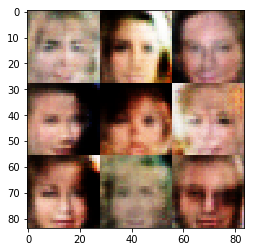

Epoch 1/2... Discriminator Loss: 0.1284... Generator Loss: 9.7317
Epoch 1/2... Discriminator Loss: 0.1313... Generator Loss: 4.7329
Epoch 1/2... Discriminator Loss: 0.0248... Generator Loss: 4.6538
Epoch 1/2... Discriminator Loss: 0.4601... Generator Loss: 4.2584
Epoch 1/2... Discriminator Loss: 0.1871... Generator Loss: 2.2898
Epoch 1/2... Discriminator Loss: 0.0321... Generator Loss: 4.5406
Epoch 1/2... Discriminator Loss: 0.2454... Generator Loss: 6.4018
Epoch 1/2... Discriminator Loss: 0.0445... Generator Loss: 4.1487
Epoch 1/2... Discriminator Loss: 0.2856... Generator Loss: 1.7035
Epoch 1/2... Discriminator Loss: 0.0230... Generator Loss: 7.9831


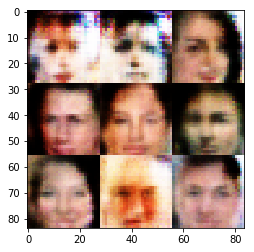

Epoch 1/2... Discriminator Loss: 0.0809... Generator Loss: 5.7630
Epoch 1/2... Discriminator Loss: 0.0415... Generator Loss: 6.3132
Epoch 1/2... Discriminator Loss: 0.0819... Generator Loss: 3.8798
Epoch 1/2... Discriminator Loss: 0.1883... Generator Loss: 6.7863
Epoch 1/2... Discriminator Loss: 1.8320... Generator Loss: 0.2310
Epoch 1/2... Discriminator Loss: 0.0732... Generator Loss: 4.1841
Epoch 1/2... Discriminator Loss: 0.1110... Generator Loss: 2.6904
Epoch 1/2... Discriminator Loss: 0.3385... Generator Loss: 1.5613
Epoch 1/2... Discriminator Loss: 0.0408... Generator Loss: 8.6601
Epoch 1/2... Discriminator Loss: 0.0387... Generator Loss: 8.5289


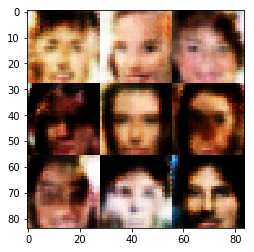

Epoch 1/2... Discriminator Loss: 0.0914... Generator Loss: 2.8719
Epoch 1/2... Discriminator Loss: 0.0332... Generator Loss: 6.7980
Epoch 1/2... Discriminator Loss: 0.1094... Generator Loss: 10.4711
Epoch 1/2... Discriminator Loss: 3.3035... Generator Loss: 7.6187
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 0.0870... Generator Loss: 7.5232
Epoch 1/2... Discriminator Loss: 0.1450... Generator Loss: 2.3841
Epoch 1/2... Discriminator Loss: 0.1188... Generator Loss: 4.4928
Epoch 1/2... Discriminator Loss: 0.0181... Generator Loss: 7.1957
Epoch 1/2... Discriminator Loss: 0.0571... Generator Loss: 7.3240


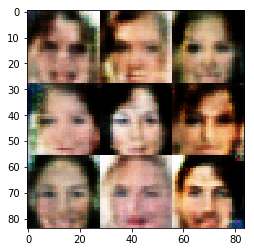

Epoch 1/2... Discriminator Loss: 0.0350... Generator Loss: 7.4177
Epoch 1/2... Discriminator Loss: 0.0205... Generator Loss: 5.5163
Epoch 1/2... Discriminator Loss: 0.0412... Generator Loss: 4.0460
Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 7.4178
Epoch 1/2... Discriminator Loss: 0.0412... Generator Loss: 4.2234
Epoch 1/2... Discriminator Loss: 0.0389... Generator Loss: 4.6588
Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 0.4973
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 0.0407... Generator Loss: 4.4832
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 1.2159


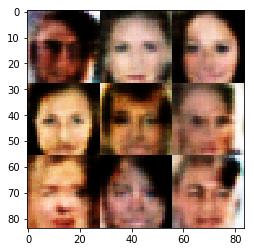

Epoch 1/2... Discriminator Loss: 0.1009... Generator Loss: 3.3455
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 1.4907
Epoch 1/2... Discriminator Loss: 0.0890... Generator Loss: 7.3253
Epoch 1/2... Discriminator Loss: 0.0744... Generator Loss: 4.0669
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 7.3515
Epoch 1/2... Discriminator Loss: 0.0774... Generator Loss: 5.6592
Epoch 1/2... Discriminator Loss: 0.6075... Generator Loss: 8.7163
Epoch 1/2... Discriminator Loss: 0.4934... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.0224... Generator Loss: 5.9548
Epoch 1/2... Discriminator Loss: 2.3813... Generator Loss: 2.9437


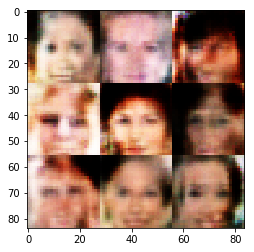

Epoch 1/2... Discriminator Loss: 0.0606... Generator Loss: 3.7247
Epoch 1/2... Discriminator Loss: 0.0348... Generator Loss: 4.7136
Epoch 1/2... Discriminator Loss: 0.0570... Generator Loss: 8.8390
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 0.0565... Generator Loss: 3.9145
Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 1.5878
Epoch 1/2... Discriminator Loss: 0.0939... Generator Loss: 4.7914
Epoch 1/2... Discriminator Loss: 2.2475... Generator Loss: 4.5851
Epoch 2/2... Discriminator Loss: 0.2501... Generator Loss: 2.5678
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 6.2296


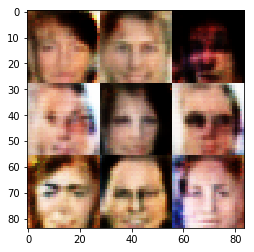

Epoch 2/2... Discriminator Loss: 0.0488... Generator Loss: 6.4135
Epoch 2/2... Discriminator Loss: 0.1376... Generator Loss: 5.5611
Epoch 2/2... Discriminator Loss: 0.0819... Generator Loss: 7.9351
Epoch 2/2... Discriminator Loss: 0.0558... Generator Loss: 7.1536
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 0.0617... Generator Loss: 6.0902
Epoch 2/2... Discriminator Loss: 0.4831... Generator Loss: 1.1452
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 8.6626
Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 5.6980
Epoch 2/2... Discriminator Loss: 0.3979... Generator Loss: 1.3771


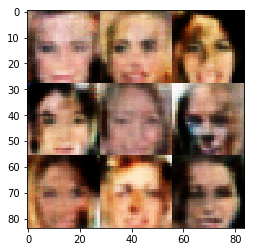

Epoch 2/2... Discriminator Loss: 0.0176... Generator Loss: 5.9586
Epoch 2/2... Discriminator Loss: 1.8004... Generator Loss: 0.2206
Epoch 2/2... Discriminator Loss: 0.0582... Generator Loss: 9.4353
Epoch 2/2... Discriminator Loss: 0.0228... Generator Loss: 4.8001
Epoch 2/2... Discriminator Loss: 0.0537... Generator Loss: 7.7260
Epoch 2/2... Discriminator Loss: 0.0451... Generator Loss: 3.8520
Epoch 2/2... Discriminator Loss: 0.0320... Generator Loss: 9.6918
Epoch 2/2... Discriminator Loss: 0.2331... Generator Loss: 7.7765
Epoch 2/2... Discriminator Loss: 0.0442... Generator Loss: 5.0281
Epoch 2/2... Discriminator Loss: 0.0433... Generator Loss: 3.8420


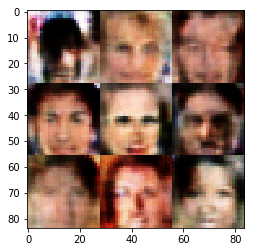

Epoch 2/2... Discriminator Loss: 0.0315... Generator Loss: 5.8548
Epoch 2/2... Discriminator Loss: 0.0361... Generator Loss: 7.2759
Epoch 2/2... Discriminator Loss: 0.0448... Generator Loss: 4.3888
Epoch 2/2... Discriminator Loss: 0.2521... Generator Loss: 2.3277
Epoch 2/2... Discriminator Loss: 0.0211... Generator Loss: 6.8971
Epoch 2/2... Discriminator Loss: 0.0231... Generator Loss: 7.7179
Epoch 2/2... Discriminator Loss: 0.0563... Generator Loss: 5.2187
Epoch 2/2... Discriminator Loss: 0.3809... Generator Loss: 1.5244
Epoch 2/2... Discriminator Loss: 0.1560... Generator Loss: 2.2489
Epoch 2/2... Discriminator Loss: 0.1147... Generator Loss: 5.6109


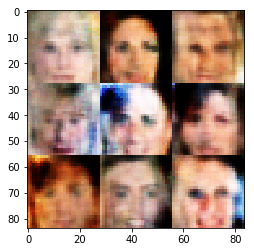

Epoch 2/2... Discriminator Loss: 0.0262... Generator Loss: 8.8995
Epoch 2/2... Discriminator Loss: 0.0655... Generator Loss: 8.3014
Epoch 2/2... Discriminator Loss: 0.1961... Generator Loss: 2.0956
Epoch 2/2... Discriminator Loss: 0.0383... Generator Loss: 4.5840
Epoch 2/2... Discriminator Loss: 0.0091... Generator Loss: 6.9915
Epoch 2/2... Discriminator Loss: 0.0542... Generator Loss: 7.7254
Epoch 2/2... Discriminator Loss: 0.1697... Generator Loss: 2.1394
Epoch 2/2... Discriminator Loss: 0.0140... Generator Loss: 8.5077
Epoch 2/2... Discriminator Loss: 2.4862... Generator Loss: 0.1535
Epoch 2/2... Discriminator Loss: 0.0820... Generator Loss: 5.5159


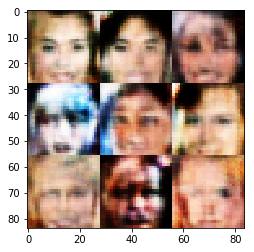

Epoch 2/2... Discriminator Loss: 0.2698... Generator Loss: 8.9947
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 1.3978
Epoch 2/2... Discriminator Loss: 0.1124... Generator Loss: 3.1253
Epoch 2/2... Discriminator Loss: 0.4512... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 0.0695... Generator Loss: 6.8695
Epoch 2/2... Discriminator Loss: 0.5748... Generator Loss: 8.7317
Epoch 2/2... Discriminator Loss: 0.0370... Generator Loss: 4.5719
Epoch 2/2... Discriminator Loss: 0.1372... Generator Loss: 6.2157
Epoch 2/2... Discriminator Loss: 0.0936... Generator Loss: 4.1615
Epoch 2/2... Discriminator Loss: 0.3610... Generator Loss: 1.5818


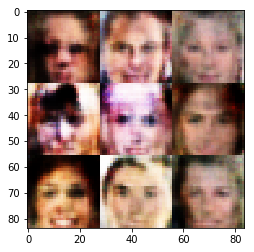

Epoch 2/2... Discriminator Loss: 0.0681... Generator Loss: 6.6685
Epoch 2/2... Discriminator Loss: 0.4688... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 0.0312... Generator Loss: 7.4528
Epoch 2/2... Discriminator Loss: 0.0803... Generator Loss: 7.1102
Epoch 2/2... Discriminator Loss: 0.3883... Generator Loss: 1.4531
Epoch 2/2... Discriminator Loss: 0.0425... Generator Loss: 4.3628
Epoch 2/2... Discriminator Loss: 0.0434... Generator Loss: 6.0063
Epoch 2/2... Discriminator Loss: 0.0711... Generator Loss: 3.5801
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 8.8281
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 1.2315


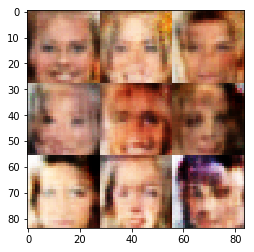

Epoch 2/2... Discriminator Loss: 0.1403... Generator Loss: 3.7200
Epoch 2/2... Discriminator Loss: 0.1796... Generator Loss: 3.1123
Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 1.5461
Epoch 2/2... Discriminator Loss: 0.1373... Generator Loss: 2.8208
Epoch 2/2... Discriminator Loss: 0.0550... Generator Loss: 6.3620
Epoch 2/2... Discriminator Loss: 0.2890... Generator Loss: 5.3728
Epoch 2/2... Discriminator Loss: 0.0784... Generator Loss: 6.3052
Epoch 2/2... Discriminator Loss: 2.6023... Generator Loss: 0.1217
Epoch 2/2... Discriminator Loss: 0.5010... Generator Loss: 1.2249
Epoch 2/2... Discriminator Loss: 0.1006... Generator Loss: 4.4272


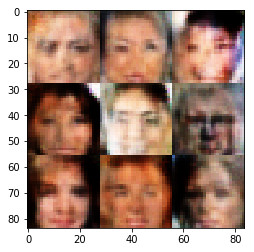

Epoch 2/2... Discriminator Loss: 0.1644... Generator Loss: 4.5416
Epoch 2/2... Discriminator Loss: 0.1922... Generator Loss: 5.0017
Epoch 2/2... Discriminator Loss: 0.0496... Generator Loss: 4.4013
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 0.5239... Generator Loss: 1.1983
Epoch 2/2... Discriminator Loss: 0.0818... Generator Loss: 4.3387
Epoch 2/2... Discriminator Loss: 0.3730... Generator Loss: 1.5410
Epoch 2/2... Discriminator Loss: 0.0435... Generator Loss: 6.5836
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.4992
Epoch 2/2... Discriminator Loss: 0.0415... Generator Loss: 7.7639


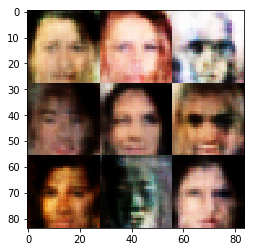

Epoch 2/2... Discriminator Loss: 0.0366... Generator Loss: 7.5522
Epoch 2/2... Discriminator Loss: 0.0867... Generator Loss: 3.8831
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 7.0108
Epoch 2/2... Discriminator Loss: 0.0563... Generator Loss: 3.5432
Epoch 2/2... Discriminator Loss: 0.0257... Generator Loss: 7.2375
Epoch 2/2... Discriminator Loss: 0.0291... Generator Loss: 5.4488
Epoch 2/2... Discriminator Loss: 2.2494... Generator Loss: 1.0156
Epoch 2/2... Discriminator Loss: 1.6763... Generator Loss: 4.0461
Epoch 2/2... Discriminator Loss: 0.1182... Generator Loss: 3.2600
Epoch 2/2... Discriminator Loss: 0.1842... Generator Loss: 4.5033


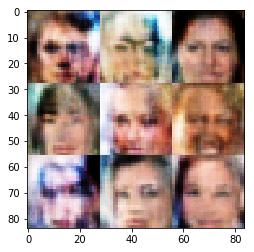

Epoch 2/2... Discriminator Loss: 0.0220... Generator Loss: 6.4998
Epoch 2/2... Discriminator Loss: 0.0907... Generator Loss: 3.6157
Epoch 2/2... Discriminator Loss: 0.1064... Generator Loss: 3.0710
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 1.4792
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 6.3623
Epoch 2/2... Discriminator Loss: 0.0328... Generator Loss: 6.9881
Epoch 2/2... Discriminator Loss: 2.0020... Generator Loss: 0.2077
Epoch 2/2... Discriminator Loss: 0.0263... Generator Loss: 7.1149
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 5.6693
Epoch 2/2... Discriminator Loss: 0.4036... Generator Loss: 1.5149


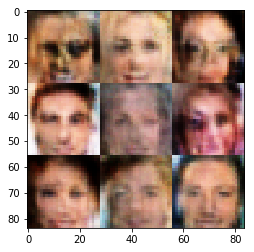

Epoch 2/2... Discriminator Loss: 0.0751... Generator Loss: 3.6136
Epoch 2/2... Discriminator Loss: 0.0705... Generator Loss: 6.9145
Epoch 2/2... Discriminator Loss: 0.0441... Generator Loss: 5.2591
Epoch 2/2... Discriminator Loss: 0.0870... Generator Loss: 3.3369
Epoch 2/2... Discriminator Loss: 0.0199... Generator Loss: 9.2333
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 5.0511
Epoch 2/2... Discriminator Loss: 0.1687... Generator Loss: 2.4688
Epoch 2/2... Discriminator Loss: 0.0261... Generator Loss: 7.2930
Epoch 2/2... Discriminator Loss: 0.0329... Generator Loss: 6.3958
Epoch 2/2... Discriminator Loss: 0.0779... Generator Loss: 5.9386


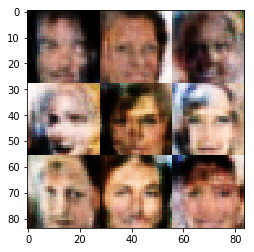

Epoch 2/2... Discriminator Loss: 0.2128... Generator Loss: 7.1714
Epoch 2/2... Discriminator Loss: 0.1808... Generator Loss: 2.4469
Epoch 2/2... Discriminator Loss: 0.1904... Generator Loss: 2.2120
Epoch 2/2... Discriminator Loss: 0.2442... Generator Loss: 8.1332
Epoch 2/2... Discriminator Loss: 0.0350... Generator Loss: 6.3539
Epoch 2/2... Discriminator Loss: 0.3192... Generator Loss: 1.6303
Epoch 2/2... Discriminator Loss: 0.2545... Generator Loss: 1.9843
Epoch 2/2... Discriminator Loss: 0.0542... Generator Loss: 8.7005
Epoch 2/2... Discriminator Loss: 0.0453... Generator Loss: 6.7468
Epoch 2/2... Discriminator Loss: 0.0945... Generator Loss: 6.0176


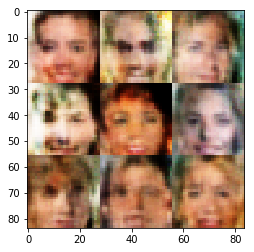

Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.4334
Epoch 2/2... Discriminator Loss: 0.1184... Generator Loss: 2.9315
Epoch 2/2... Discriminator Loss: 0.3104... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 0.1294... Generator Loss: 2.8416
Epoch 2/2... Discriminator Loss: 0.1164... Generator Loss: 5.3100
Epoch 2/2... Discriminator Loss: 0.0362... Generator Loss: 8.4465
Epoch 2/2... Discriminator Loss: 0.0529... Generator Loss: 7.0608
Epoch 2/2... Discriminator Loss: 0.0127... Generator Loss: 6.5030
Epoch 2/2... Discriminator Loss: 0.0560... Generator Loss: 4.9996
Epoch 2/2... Discriminator Loss: 0.3058... Generator Loss: 1.7395


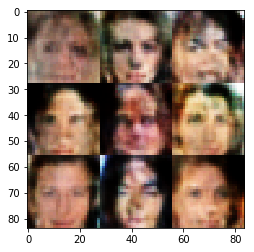

Epoch 2/2... Discriminator Loss: 0.2253... Generator Loss: 2.6856
Epoch 2/2... Discriminator Loss: 0.1134... Generator Loss: 4.4446
Epoch 2/2... Discriminator Loss: 0.2846... Generator Loss: 2.2018
Epoch 2/2... Discriminator Loss: 0.1949... Generator Loss: 4.7512
Epoch 2/2... Discriminator Loss: 0.3633... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 3.4150
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.9610
Epoch 2/2... Discriminator Loss: 0.0873... Generator Loss: 3.9458
Epoch 2/2... Discriminator Loss: 0.1018... Generator Loss: 2.9907
Epoch 2/2... Discriminator Loss: 0.1755... Generator Loss: 2.9532


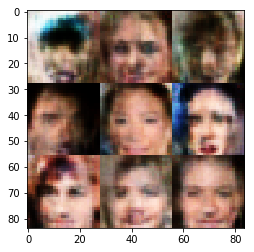

Epoch 2/2... Discriminator Loss: 0.1743... Generator Loss: 2.2967
Epoch 2/2... Discriminator Loss: 0.1178... Generator Loss: 3.4424
Epoch 2/2... Discriminator Loss: 0.0569... Generator Loss: 4.9331
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.5328
Epoch 2/2... Discriminator Loss: 0.1521... Generator Loss: 2.9651
Epoch 2/2... Discriminator Loss: 0.0495... Generator Loss: 3.9703
Epoch 2/2... Discriminator Loss: 5.3920... Generator Loss: 7.8740
Epoch 2/2... Discriminator Loss: 0.2241... Generator Loss: 2.8896
Epoch 2/2... Discriminator Loss: 0.3078... Generator Loss: 1.9289
Epoch 2/2... Discriminator Loss: 0.0558... Generator Loss: 4.4791


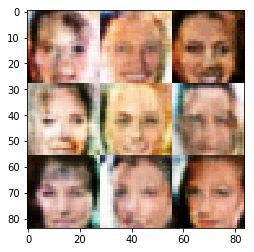

Epoch 2/2... Discriminator Loss: 0.0593... Generator Loss: 7.1179
Epoch 2/2... Discriminator Loss: 0.0528... Generator Loss: 7.3847
Epoch 2/2... Discriminator Loss: 0.0826... Generator Loss: 3.2332
Epoch 2/2... Discriminator Loss: 0.1141... Generator Loss: 7.3155
Epoch 2/2... Discriminator Loss: 0.1966... Generator Loss: 4.3380
Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 4.3937


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.